<a href="https://colab.research.google.com/github/prakashradhakrish/Segmentation-using-UNet-Architecture/blob/master/Pedestrian_class_cityscape_Group_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unet in Cityscape**#

---
#![alt text](https://drive.google.com/uc?id=1gesaCGGIDJFhpKmejb7tFyv-vAj_aIDf)


---


# **Initialisation**

In [1]:
# initialising 
import numpy as np
import torch
import os
import re
import cv2
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as func
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from IPython.display import HTML, display
from torchvision import transforms,datasets,utils
%matplotlib inline
from torch.utils.data import DataLoader, TensorDataset


# **Dataset creation for pedestrian segmentation**

**List of steps for creating dataset**

*   Liniking the Cityscape train and test image from Google drive
*   Resizing and storing the images as 400x400 done seperately in another code
*   Adding the images directly to dataloader




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Dataset creation based on new data image
transform = transforms.Compose([transforms.ToTensor()]) # Converting to tensor dataset

train_set = torchvision.datasets.Cityscapes(root = "/content/drive/My Drive/Dataset/cityscape_400x400/", split='train', mode='fine', target_type='semantic', transform=transform , target_transform=transform , transforms=None)
test_set = torchvision.datasets.Cityscapes(root = "/content/drive/My Drive/Dataset/cityscape_400x400/", split='val', mode='fine', target_type='semantic', transform=transform , target_transform=transform , transforms=None)

batch_size = 5

# creating data loader for train and test
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
    'test': DataLoader(test_set, batch_size=1, shuffle=True, num_workers=2)
}

# **Model creation**#

**Input size of image** : (3, 400, 400)

**Input type** : Tensor

**Output size of image** : (2, 400, 400) -> **Channel information:** pedestrian and background

**List of Unet models created for studies. Categorised based on parameters**

*   unet_5k - 5,938 parameters
*   unet_50k - 48,018 parameters 
*   unet_100k - 138000 parameters 
*   unet_3M - 3,873,986 parameters
*   unet_7M - 7,782,978 parameters

**5000 Parameters**

In [4]:
class unet_5k(nn.Module):
  def __init__(self):
    super(unet_5k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 8, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_2to1 = nn.ConvTranspose2d(16, 16, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(16+8, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)
    

  def forward(self, x):
      #x = x.view(-1, 128 * 128)
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = torch.cat([self.upsampling_2to1(x3,output_size=x1.size()), x1], dim=1)
      x5 = self.explayer5(x4)
      x6 = self.output_conv(x5)
      return x6   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_5k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 400, 400]             224
              ReLU-2          [-1, 8, 400, 400]               0
         MaxPool2d-3          [-1, 8, 200, 200]               0
            Conv2d-4         [-1, 16, 200, 200]           1,168
              ReLU-5         [-1, 16, 200, 200]               0
   ConvTranspose2d-6         [-1, 16, 400, 400]           1,040
            Conv2d-7         [-1, 16, 400, 400]           3,472
              ReLU-8         [-1, 16, 400, 400]               0
            Conv2d-9          [-1, 2, 400, 400]              34
Total params: 5,938
Trainable params: 5,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.83
Forward/backward pass size (MB): 92.77
Params size (MB): 0.02
Estimated Total Size (MB): 94.63
---------------------------------------------

**50kParameters**

In [5]:
class unet_50k(nn.Module):
  def __init__(self):
    super(unet_50k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_3to2 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer4 = nn.Sequential(nn.Conv2d(32+32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)

  def forward(self, x):
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = self.downsampling(x3)
      x5 = self.contractinglayer3(x4)
      x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      x7 = self.explayer4(x6)
      x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
      x9 = self.explayer5(x8)
      x10 = self.output_conv(x9)
      return x10   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_50k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
              ReLU-2         [-1, 16, 400, 400]               0
         MaxPool2d-3         [-1, 16, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           4,640
              ReLU-5         [-1, 32, 200, 200]               0
         MaxPool2d-6         [-1, 32, 100, 100]               0
            Conv2d-7         [-1, 32, 100, 100]           9,248
              ReLU-8         [-1, 32, 100, 100]               0
   ConvTranspose2d-9         [-1, 32, 200, 200]           4,128
           Conv2d-10         [-1, 32, 200, 200]          18,464
             ReLU-11         [-1, 32, 200, 200]               0
  ConvTranspose2d-12         [-1, 32, 400, 400]           4,128
           Conv2d-13         [-1, 16, 400, 400]           6,928
             ReLU-14         [-1, 16, 4

**100kParameters** - 0.01M

In [6]:
class unet_100k(nn.Module):
  def __init__(self):
    super(unet_100k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_3to2 = nn.ConvTranspose2d(64, 64, 2,stride=2, padding=0)
    self.explayer4 = nn.Sequential(nn.Conv2d(64+32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)

  def forward(self, x):
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = self.downsampling(x3)
      x5 = self.contractinglayer3(x4)
      x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      x7 = self.explayer4(x6)
      x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
      x9 = self.explayer5(x8)
      x10 = self.output_conv(x9)
      return x10   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_100k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
              ReLU-2         [-1, 16, 400, 400]               0
            Conv2d-3         [-1, 16, 400, 400]           2,320
              ReLU-4         [-1, 16, 400, 400]               0
         MaxPool2d-5         [-1, 16, 200, 200]               0
            Conv2d-6         [-1, 32, 200, 200]           4,640
              ReLU-7         [-1, 32, 200, 200]               0
            Conv2d-8         [-1, 32, 200, 200]           9,248
              ReLU-9         [-1, 32, 200, 200]               0
        MaxPool2d-10         [-1, 32, 100, 100]               0
           Conv2d-11         [-1, 64, 100, 100]          18,496
             ReLU-12         [-1, 64, 100, 100]               0
           Conv2d-13         [-1, 64, 100, 100]          36,928
             ReLU-14         [-1, 64, 1

**3 Million parameters**

In [7]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   


class UNet_3M(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 2, 1,stride=1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_3M()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
         MaxPool2d-3         [-1, 64, 200, 200]               0
            Conv2d-4        [-1, 128, 200, 200]          73,856
              ReLU-5        [-1, 128, 200, 200]               0
         MaxPool2d-6        [-1, 128, 100, 100]               0
            Conv2d-7        [-1, 256, 100, 100]         295,168
              ReLU-8        [-1, 256, 100, 100]               0
         MaxPool2d-9          [-1, 256, 50, 50]               0
           Conv2d-10          [-1, 512, 50, 50]       1,180,160
             ReLU-11          [-1, 512, 50, 50]               0
         Upsample-12        [-1, 512, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]       1,769,728
             ReLU-14        [-1, 256, 1

**7 Million parameters**

In [8]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet_7M(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 2, 1,stride=1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_7M()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
         MaxPool2d-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
              ReLU-7        [-1, 128, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]         147,584
              ReLU-9        [-1, 128, 200, 200]               0
        MaxPool2d-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         295,168
             ReLU-12        [-1, 256, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]         590,080
             ReLU-14        [-1, 256, 1

# **Information to be set**

Requires input from the user

In [13]:
picking_architecture = 4 #required user input to choose architecture from 0 to 4
n_class =2 # enter the number of class here
num_epochs =50 # enter number of epochs

unetslist = [unet_5k(),unet_50k(),unet_100k(),UNet_3M(),UNet_7M()] # to select the model to train
unetsavelist = ["unet_5k_city.pth","unet_50k_city.pth","unet_100k_city.pth","UNet_3M_city.pth","UNet_7M_city.pth"] # to save the model

**Function for splitting the masking labels to channel required for training**

In [14]:
def label_split(labels,targetimage,n_class):
  for i in range(n_class):
    if i==0:
      labels[:,0,:,:] = (targetimage== 0)==1
    else:
        labels[:,i,:,:] = (targetimage!= i)==0
  return labels


# **Loss function**

**Using Dice loss with BCE loss**

**Dice loss function**

In [15]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

**Dice loss function with BCE**

In [16]:
from collections import defaultdict
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

def calc_loss(pred, target, bce_weight=0.5):
    bce = func.binary_cross_entropy_with_logits(pred, target).type(dtype)

    pred = torch.sigmoid(pred).type(dtype)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss

# **Optimizer**

In [17]:
unet = unetslist[picking_architecture]
print("Architecture choosen with parameters: " + str(sum(p.numel() for p in unet.parameters())))
gpu_available = torch.cuda.is_available() 
if gpu_available:
    unet = unet.cuda()
    
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, unet.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


Architecture choosen with parameters: 7782978


**Load the pretrained dataset here if available**

**Note:**

* Ensure the directory is correct to search the .pth file
* Ensure correct name for .pth file matching the choosen model architecture
* If architecture matched we will see: **All keys matched successfully**

In [18]:
unet.load_state_dict(torch.load(os.path.join("/content/drive/My Drive/Dataset/PennFudanPed/","UNet_7M.pth")))

<All keys matched successfully>

# **Training**

In [ ]:
loss_values =[]
running_loss = 0.0

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)


    scheduler.step()
    for param_group in optimizer.param_groups:
      print("LR", param_group['lr'])

    for i, data in enumerate(dataloaders['train']):
        inputimage, targetimage = data
        if gpu_available:
            inputimage = inputimage.cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputimage)
      

        labels = torch.empty_like(outputs)
        lab_channel = (label_split(labels,targetimage.squeeze(1),n_class)).cuda()


        loss = calc_loss(outputs,lab_channel)

        #loss += lmbd * reg_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 10 == 9:
            print('[%d, %5d] loss: %.10f' %(epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / 170)
            running_loss = 0.0


**Dont run the save command if the training is not performed**

In [ ]:
torch.save(unet.state_dict(), os.path.join("/content/drive/My Drive/Dataset/cityscape_400x400/","unet_7M_fine_w_pennfudan"))

# **Testing**

**Load the pretrained dataset here if available**

**Note:**

* Ensure the directory is correct to search the .pth file
* Ensure correct name for .pth file matching the choosen model architecture
* If architecture matched we will see: **All keys matched successfully**

In [21]:
unet.load_state_dict(torch.load(os.path.join("/content/drive/My Drive/Dataset/cityscape_400x400/","unet_7M_fine_w_pennfudan")))

<All keys matched successfully>

**IOU metrics**

In [19]:
def iou(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) 
    #print(intersection,union)
   
    loss = ((intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) - intersection + smooth))
    
    return loss.mean()

**Checking the IOU for our test set**

Change the Iou threshold if needed

In [22]:
iou_threshold = 0.6 # enter the threshold for IOU metrics
correct_prediction = 0
total_prediction = 0
for i, data in enumerate(dataloaders['test']):
    inputimage, targetimage = data
    
    if gpu_available:
        inputimage = inputimage.cuda() 
        targetimage =  targetimage.squeeze(0).cuda()
        

    prediction = unet(inputimage)
    prediction = torch.sigmoid(prediction)  

    lab_channel = torch.empty_like(prediction)
    lab_channel[:,0,:,:] = 1 - targetimage
    lab_channel[:,1,:,:] = targetimage
    lab_channel = lab_channel.cuda()

    loss_raw = ((iou(prediction,lab_channel,1e-9)).cpu())
    #print(loss_raw)

    total_prediction = total_prediction + 1
    if loss_raw > iou_threshold:
      correct_prediction = correct_prediction + 1

print("IOU: " + str(correct_prediction/total_prediction) +str(" for IOU threshold of: ") + str(iou_threshold))

IOU: 0.7881040892193308 for IOU threshold of: 0.6


**Visualising the predicted output**

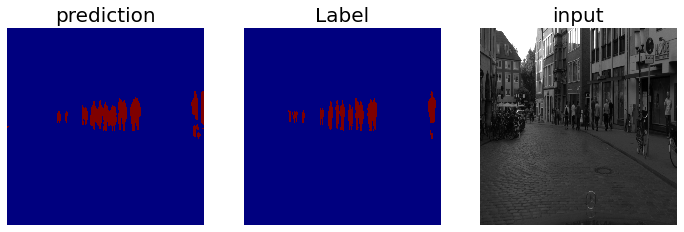

In [27]:
import math

# Get the first batch
inputs1, targetimage = next(iter(dataloaders['test']))
inputs = inputs1.cuda()


# Predict
pred = unet(inputs)

# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred_max = torch.argmax(pred, dim=1)

#printing image
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12),facecolor='w')
ax1.imshow(pred_max.squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax2.imshow(targetimage.squeeze(0).squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax3.imshow((inputs1.squeeze(0).cpu())[1,:,:],  interpolation='none',cmap='gray')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('prediction',fontsize=20)
ax2.set_title('Label',fontsize=20)
ax3.set_title('input',fontsize=20)
plt.show()


TO be checked for images obtained from net